In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc
import os
import geoplot
import geopandas
import pycountry
from github import Github
from datetime import datetime, timedelta
from functools import reduce

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
combined_dataframe_name = "combined_df.csv"
df = pd.read_csv(combined_dataframe_name, index_col=0, header=[0, 1])
df.head()

2020-03-08 00:00:00                                 \
                        confirmed deaths recovered active tweets   
Aruba                           0      0         0      0    105   
Afghanistan                     4      0         0      4    252   
Angola                          0      0         0      0    191   
Anguilla                        0      0         0      0     15   
Åland Islands                   0      0         0      0     24   

              2020-03-09 00:00:00                                 ...  \
                        confirmed deaths recovered active tweets  ...   
Aruba                           0      0         0      0    227  ...   
Afghanistan                     4      0         0      4    458  ...   
Angola                          0      0         0      0    360  ...   
Anguilla                        0      0         0      0     22  ...   
Åland Islands                   0      0         0      0     40  ...   

              2020-04-10 00:00:00                                 \
                        confirmed deaths recovered active tweets   
Aruba                           4      0         0      4   2752   
Afghanistan                   521     15        32    474  13636   
Angola                         19      2         2     15  10614   
Anguilla                        0      0         0      0    354   
Åland Islands                   0      0         0      0    708   

              2020-04-11 00:00:00                                 
                        confirmed deaths recovered active tweets  
Aruba                           4      0         0      4   2817  
Afghanistan                   555     18        32    505  14158  
Angola                         19      2         4     13  10850  
Anguilla                        0      0         0      0    389  
Åland Islands                   0      0         0      0    755  

[5 rows x 175 columns]

In [3]:
def plot_for_regions(regions_list, plot_confirmed=True, plot_deaths=True, plot_recoveries=True, plot_active=False, plot_tweets=True):
    if len(regions_list) == 0:
        selected_regions_stats = df.sum()
    else:
        selected_regions_stats = df.reindex(regions_list).sum()
    confirmed = list(selected_regions_stats[:, 'confirmed'])
    deaths = list(selected_regions_stats[:, 'deaths'])
    recovered = list(selected_regions_stats[:, 'recovered'])
    active = list(selected_regions_stats[:, 'active'])
    tweets = list(selected_regions_stats[:, 'tweets'])
    
    dates = np.unique(df.columns.get_level_values(0))
    dates = [datetime.strptime(dates[i], '%Y-%m-%d %H:%M:%S') for i in range(len(dates))]

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) == 0:
        ax.set_title('COVID data for whole Earth')
    elif len(regions_list) == 1:
        ax.set_title('COVID data for ' + str(regions_list[0]))
    else:
        ax.set_title('COVID data for countries: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of cases')
        
    if plot_confirmed:
        ax.plot(dates, confirmed, 'o-', c='gold', label='confirmed cases')
    if plot_deaths:
        ax.plot(dates, deaths, 'o-', c='red', label='deaths')
    if plot_recoveries:
        ax.plot(dates, recovered, 'o-', c='green', label='recoveries')
    if plot_active:
        ax.plot(dates, active, 'o-', c='pink', label='active cases')
    
    if plot_tweets:
        ax_tweets = ax.twinx()
        ax_tweets.set_ylabel('Number of tweets')
        ax_tweets.plot(dates, tweets, 'o-', c='lightblue', label='tweets sent')
        ax_tweets.legend(loc=1)
    
    ax.legend(loc=2)
    plt.show()

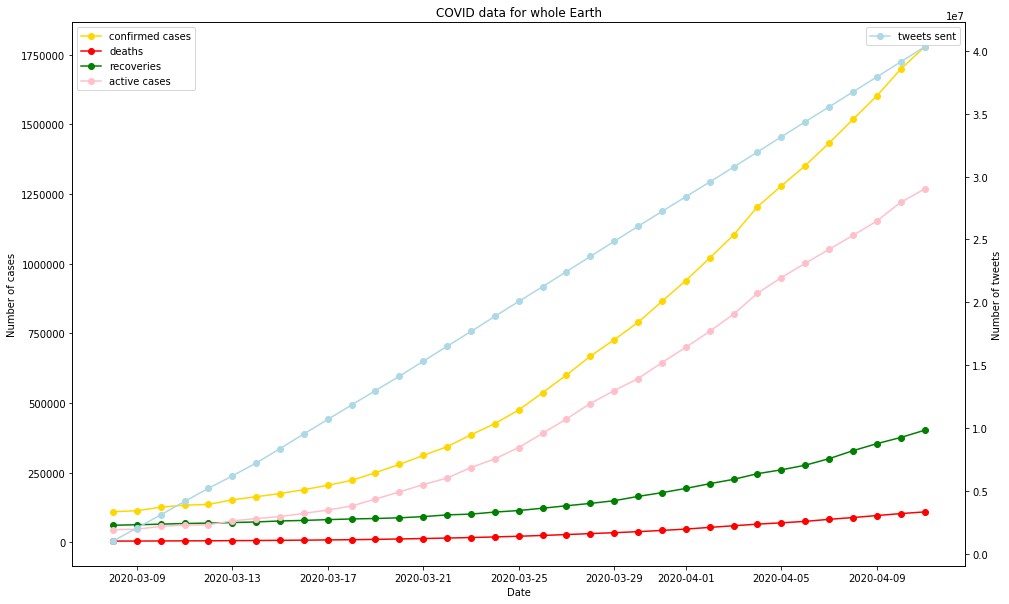

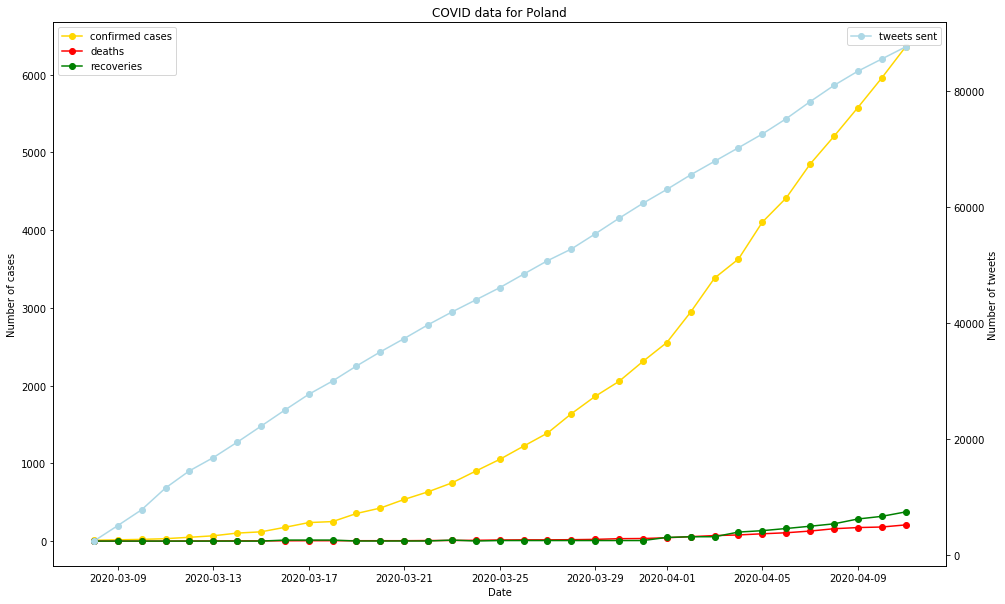

In [4]:
plot_for_regions([], plot_active=True)
plot_for_regions(['Poland'])

In [5]:
def barplot_for_regions(regions_list, plot_tweets='dot'):
    if len(regions_list) == 0:
        selected_regions_stats = df.sum()
    else:
        selected_regions_stats = df.reindex(regions_list).sum()
    confirmed = list(selected_regions_stats[:, 'confirmed'])
    deaths = list(selected_regions_stats[:, 'deaths'])
    recovered = list(selected_regions_stats[:, 'recovered'])
    active = list(selected_regions_stats[:, 'active'])
    tweets = list(selected_regions_stats[:, 'tweets'])
    
    dates = np.unique(df.columns.get_level_values(0))
    dates = np.array([datetime.strptime(dates[i], '%Y-%m-%d %H:%M:%S') for i in range(len(dates))])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) == 0:
        ax.set_title('COVID data for whole Earth')
    elif len(regions_list) == 1:
        ax.set_title('COVID data for ' + str(regions_list[0]))
    else:
        ax.set_title('COVID data for countries: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of cases')
        
    width = timedelta(hours=10) if plot_tweets == 'bar' else 0.8
        
    ax.bar(dates, deaths, width=width, color='red', label='deaths')
    ax.bar(dates, active, width=width, color='pink', bottom=deaths, label='active cases')
    active_and_deaths = np.array(active) + np.array(deaths)
    ax.bar(dates, recovered, width=width, color='green', bottom=active_and_deaths, label='recoveries')
    
    if plot_tweets == 'bar':
        ax_tweets = ax.twinx()
        ax_tweets.set_ylabel('Number of tweets')
        ax_tweets.bar(dates + width, tweets, width=width, color='lightblue', label='tweets sent')
        ax_tweets.legend(loc=1)  
    elif plot_tweets == 'dot':
        ax_tweets = ax.twinx()
        ax_tweets.set_ylabel('Number of tweets')
        ax_tweets.plot(dates, tweets, 'o', c='lightblue', label='tweets sent', markersize=10)
        ax_tweets.legend(loc=1)
    
    ax.legend(loc=2)
    plt.show()

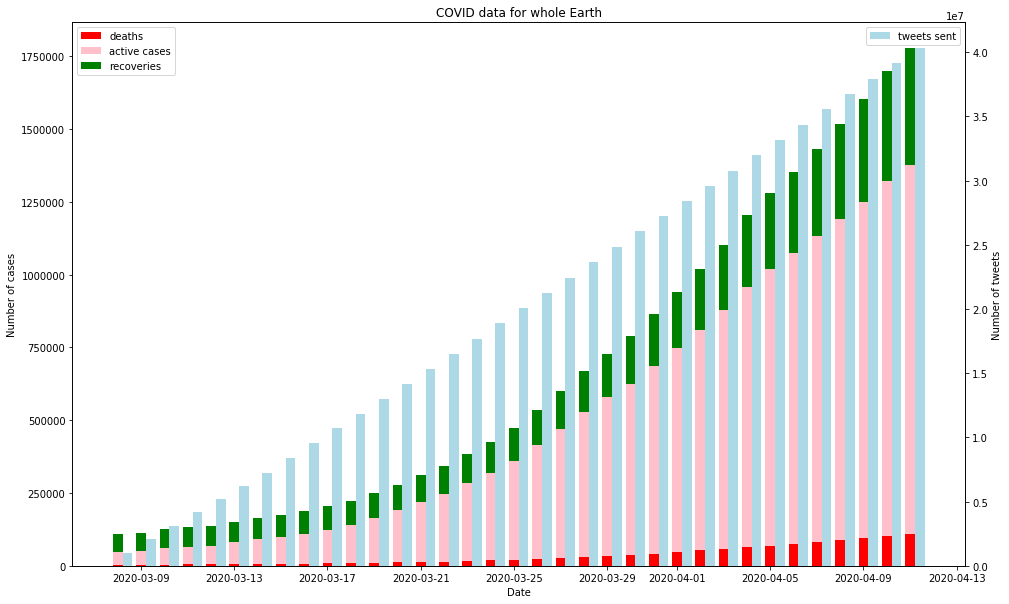

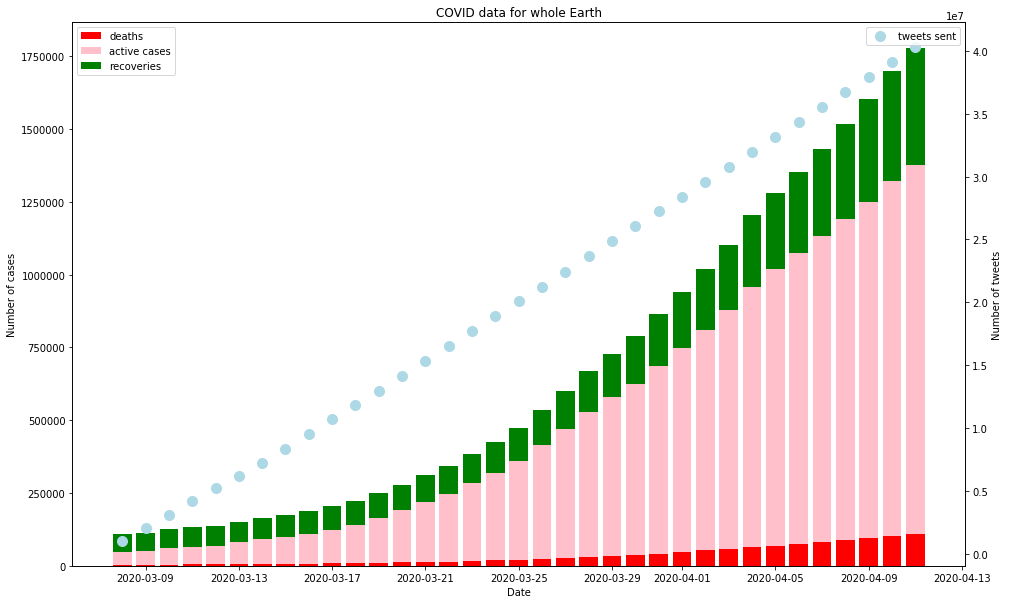

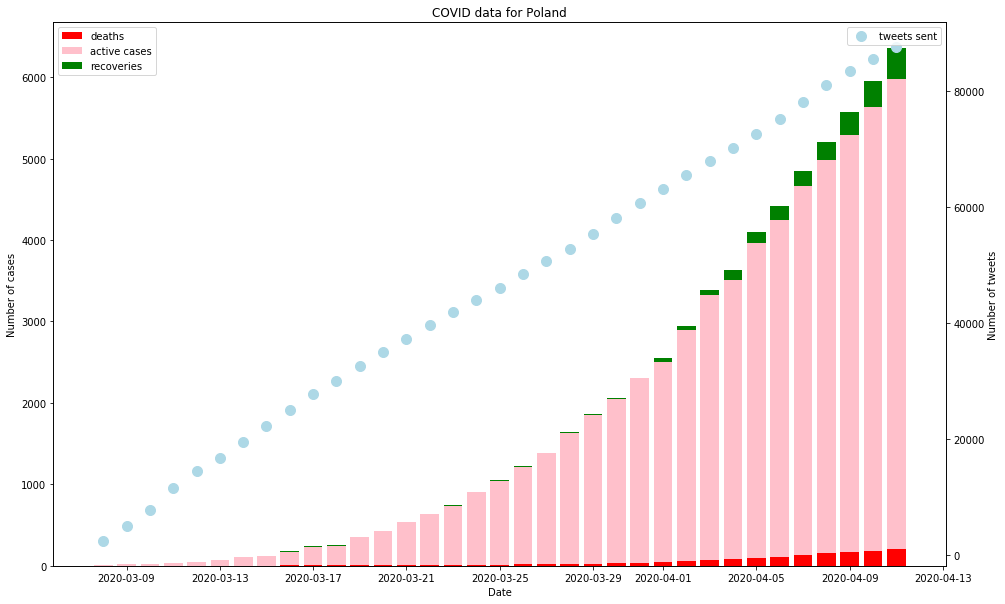

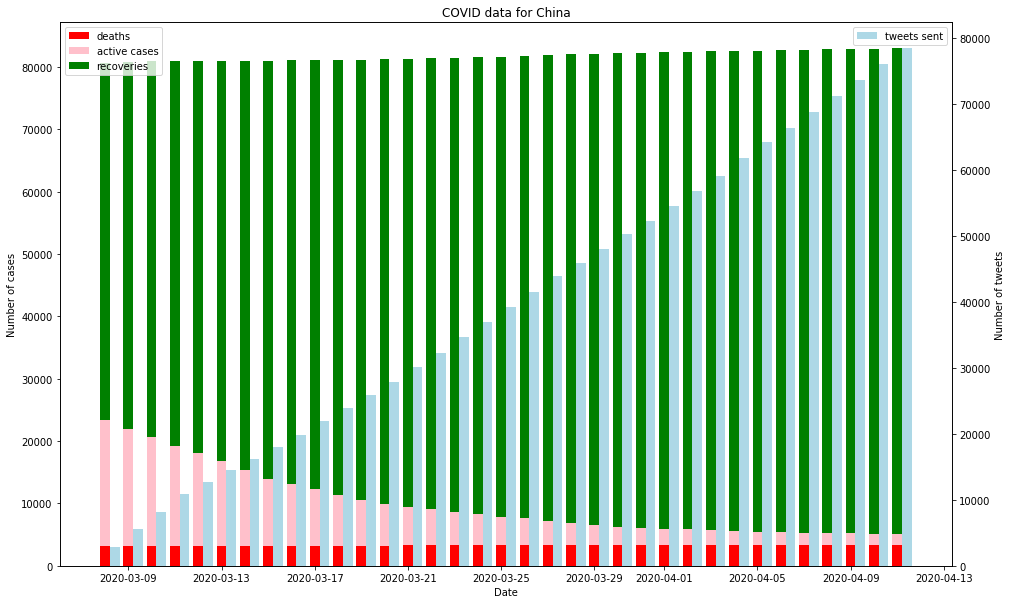

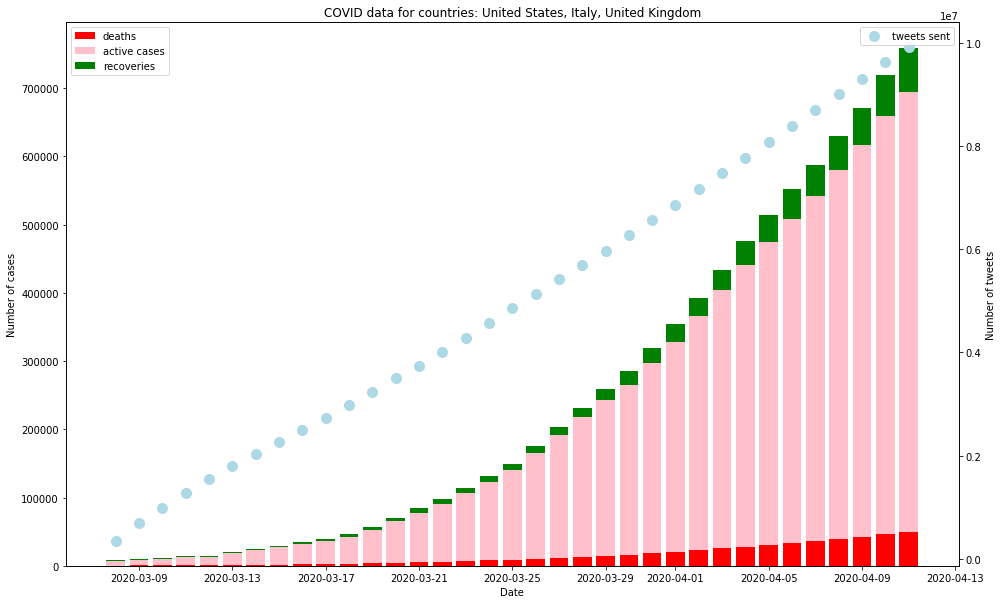

In [6]:
barplot_for_regions([], plot_tweets='bar')
barplot_for_regions([], plot_tweets='dot')
barplot_for_regions(['Poland'], plot_tweets='dot')
barplot_for_regions(['China'], plot_tweets='bar')
barplot_for_regions(['United States', 'Italy', 'United Kingdom'], plot_tweets='dot')

# Plotting data on map

### Preparing world map dataframe and unifying countries names

In [7]:
map_df_countries_proper_names = {
    'W. Sahara': 'Western Sahara',
    'Dem. Rep. Congo': 'Congo',
    'Dominican Rep.': 'Dominican Republic',
    'Falkland Is.': 'Falkland Islands (Malvinas)',
    'Fr. S. Antarctic Lands': 'Antarctica',
    'Central African Rep.': 'Central African Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'Laos': 'Lao People\'s Democratic Republic',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Solomon Is.': 'Solomon Islands',
    'N. Cyprus': 'Cyprus',
    'Somaliland': 'Somalia',
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'S. Sudan': 'South Sudan',
}
map_df = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
map_df.replace({'name': map_df_countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in map_df['name']]
map_df['name'] = new_countries_names
map_df = map_df.rename(columns={'name': 'country'})
map_df.head()

,country,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,"Tanzania, United Republic of","POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing population dataframe and unifying countries names

In [8]:
population_df_countries_proper_names = {
    'DR Congo': 'Congo',
    'South Korea': 'Korea, Republic of',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Swaziland': 'Eswatini',
    'Macau': 'Macao',
    'Cape Verde': 'Cabo Verde',
    'United States Virgin Islands': 'United States',
}
population_df = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population_df["pop2020"] *= 1000
population_df = population_df.astype({'pop2020': 'int32'}, copy=False)
population_df.replace({'name': population_df_countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in population_df['name']]
population_df['name'] = new_countries_names
population_df = population_df.groupby('name', as_index=False).sum()
population_df = population_df.rename(columns={'name': 'country', 'pop2020': 'population'})
population_df.head()

,country,population
0,Afghanistan,38928346
1,Albania,2877797
2,Algeria,43851044
3,American Samoa,55191
4,Andorra,77265


### functions for creating df for given dates range and plotting data on map

In [9]:
def plot_map(dataframe, column_name, title=''):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '24'})
    dataframe.plot(column=column_name, cmap='Greys', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.show()

def plot_map_for_dates_range(dates_range, df=df, map_df=map_df, population_df=population_df, column_to_plot='tweets', title=''):
    dataframe = get_map_df_for_dates_range(dates_range, df, map_df, population_df)
    plot_map(dataframe, column_to_plot, title)   

def get_map_df_for_dates_range(dates_range, df=df, map_df=map_df, population_df=population_df, print_dates_range=False):
    starting_index = (dates_range[0] - 1) * 5
    ending_index = dates_range[1] * 5

    before = []
    after = []
    for i in range(5):
        before.append(np.array(df.iloc[:, starting_index + i]) if starting_index >= 0 else np.zeros(df.shape[0], dtype=np.int))
        after.append(np.array(df.iloc[:, ending_index + i]))
     
    data = dict()
    for i, statistic in enumerate(['confirmed', 'deaths', 'recovered', 'active', 'tweets']):
        data[statistic] = after[i] - before[i]
   
    dataframe = pd.DataFrame(data=data, index=df.index)

    # add population and statistics per person columns to the dataframe
    dataframe = dataframe.join(population_df.set_index('country'))
    dataframe = dataframe.dropna(axis='index')
    for statistic in ['confirmed', 'deaths', 'recovered', 'active', 'tweets']:
        dataframe[statistic + ' per person'] = dataframe[statistic] / dataframe['population']
    
    # add map geometry column to the dataframe
    dataframe = map_df.set_index('country').join(dataframe)
    dataframe.fillna(0, inplace=True)
    
    if print_dates_range:
        print('Dataframe contains combined daily increments of statistics for dates range')
        print('from', df.columns[starting_index + 5][0][:10], 'to', df.columns[ending_index][0][:10], '(inclusive)')
        
    return dataframe

def visualize_statistic_for_dates_range(dates_ranges, statistic, df=df, map_df=map_df, population_df=population_df):
    for dates_range in dates_ranges:
        title = 'New ' + statistic + '\nfrom ' + df.columns[dates_range[0] * 5][0][:10] \
            + ' to ' + df.columns[dates_range[1] * 5][0][:10] + ' (inclusive)'
        plot_map_for_dates_range(dates_range, df, map_df, population_df, statistic, title)

### Plotting given statistic increase during given dates ranges on map 

In [10]:
print('Number of days with cumulative data', int(df.shape[1] / 5))
print('For dates ranges use indices from 1 to', int(df.shape[1] / 5 - 1))
print('Do not use index 0, since generated df\'s contain combined daily increase data')
print('and it is not possible to get daily increase for first known data')

Number of days with cumulative data 35
For dates ranges use indices from 1 to 34
Do not use index 0, since generated df's contain combined daily increase data
and it is not possible to get daily increase for first known data


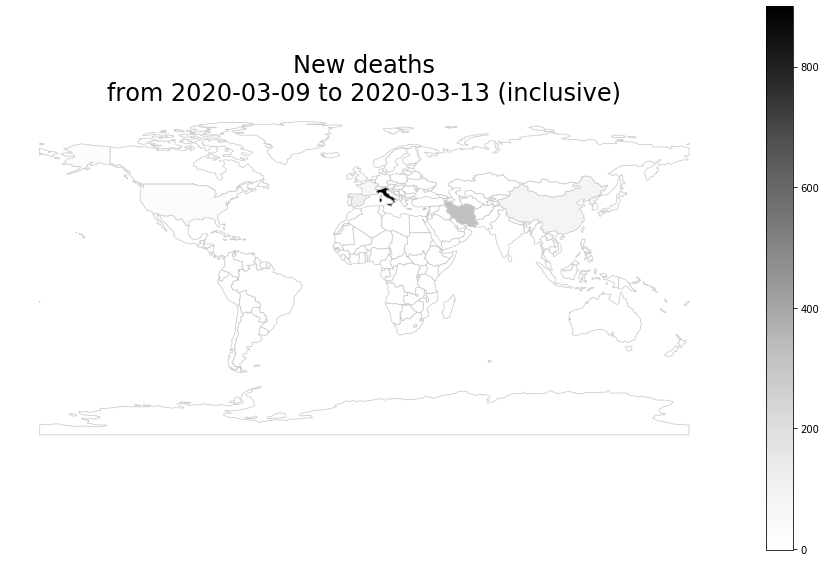

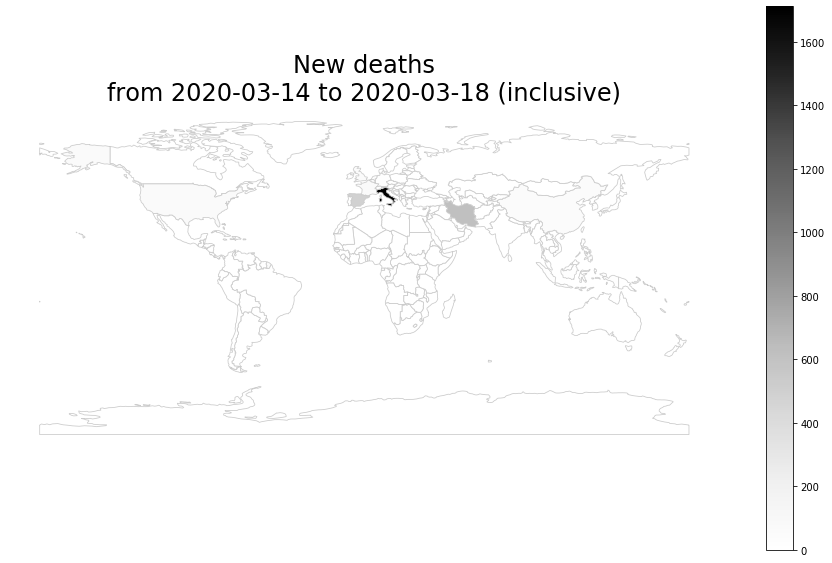

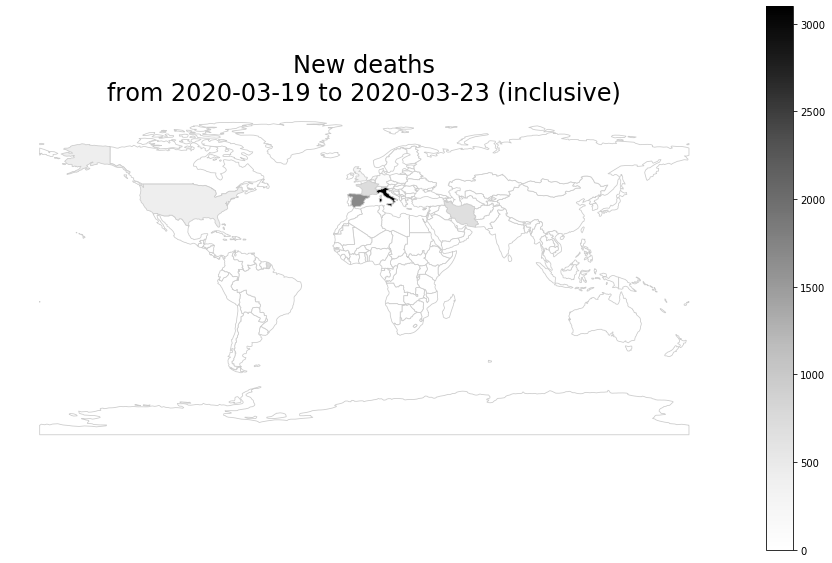

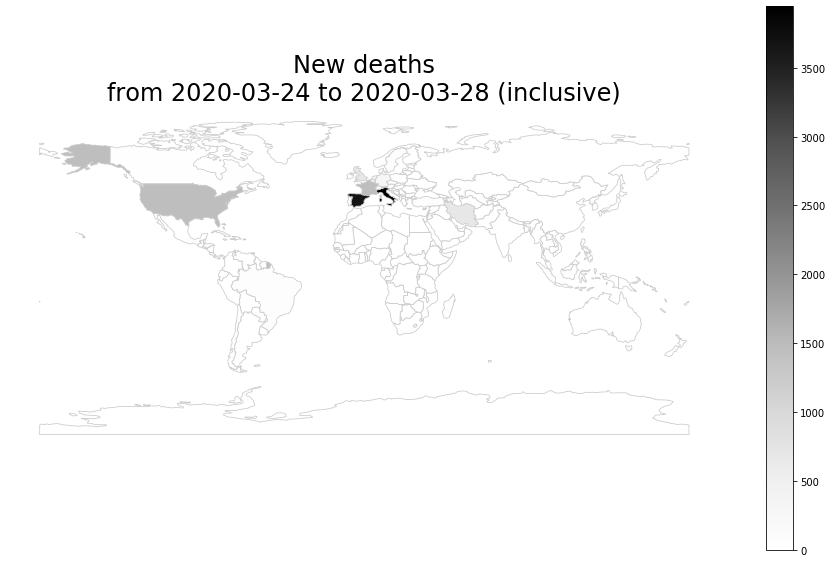

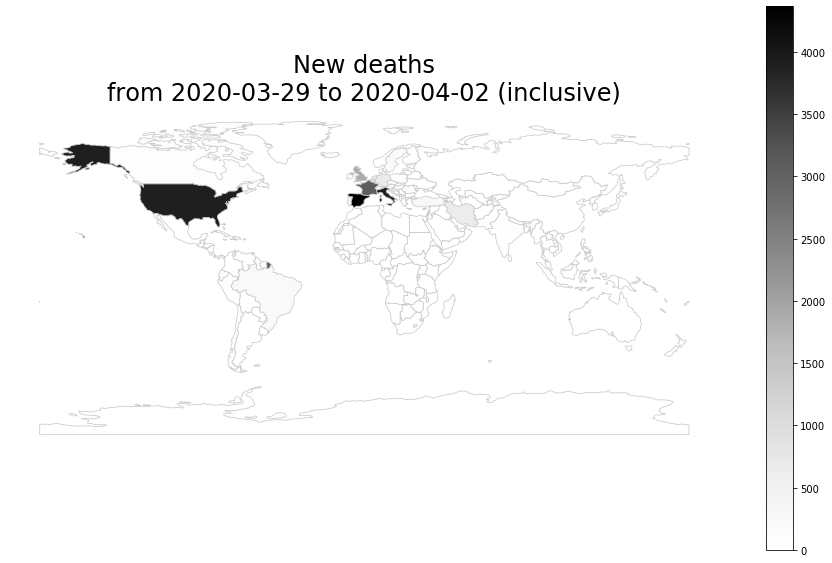

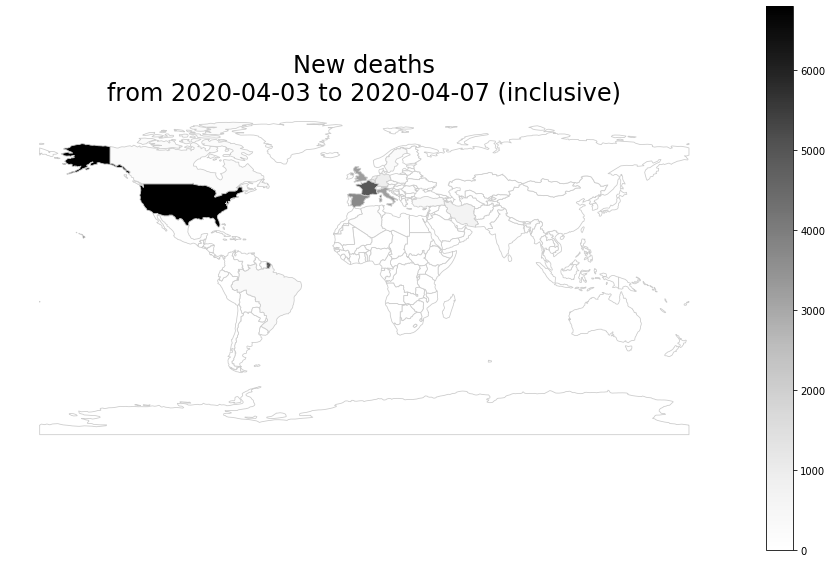

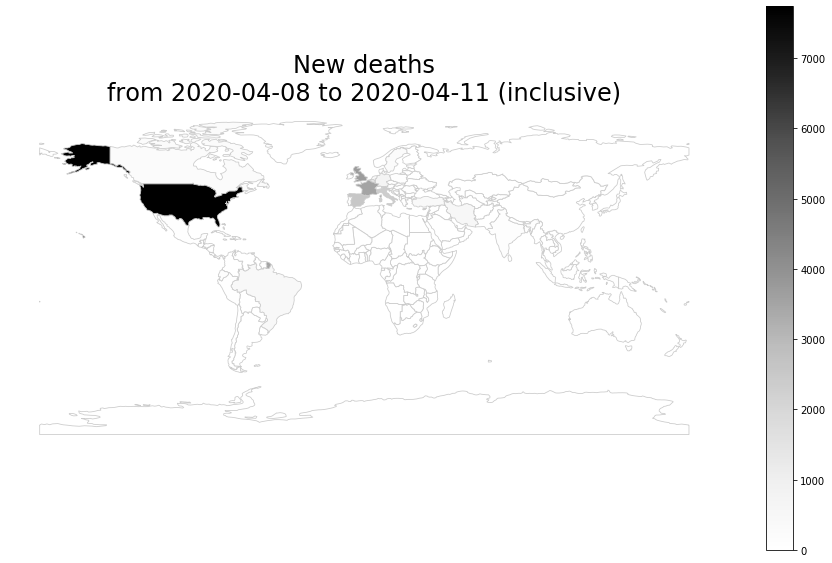

In [11]:
statistic_to_visualise = 'deaths'
dates_ranges_to_visualise = [
    (1, 5),
    (6, 10),
    (11, 15),
    (16, 20),
    (21, 25),
    (26, 30),
    (31, 34),
]

visualize_statistic_for_dates_range(dates_ranges_to_visualise, statistic_to_visualise)

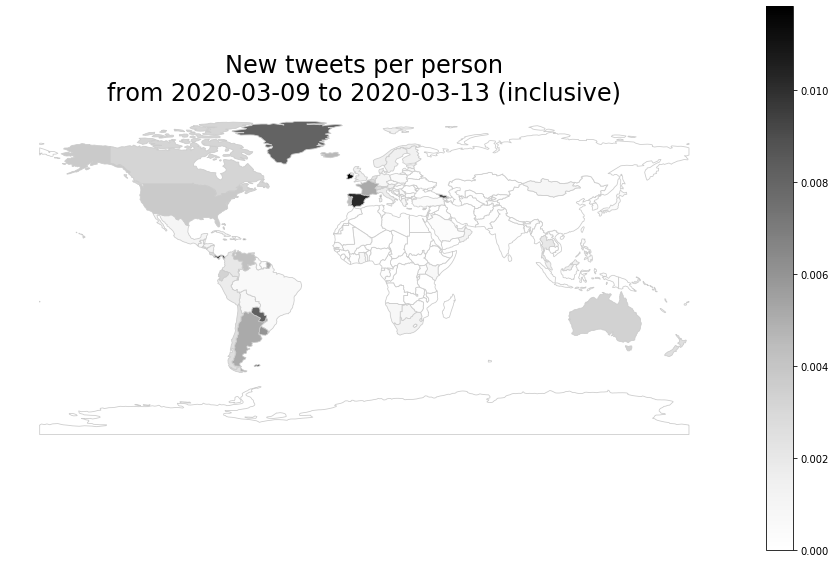

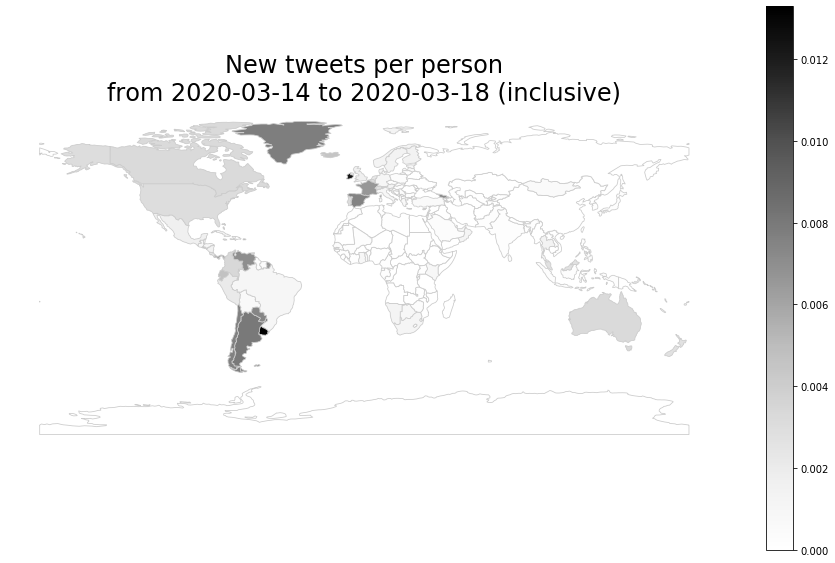

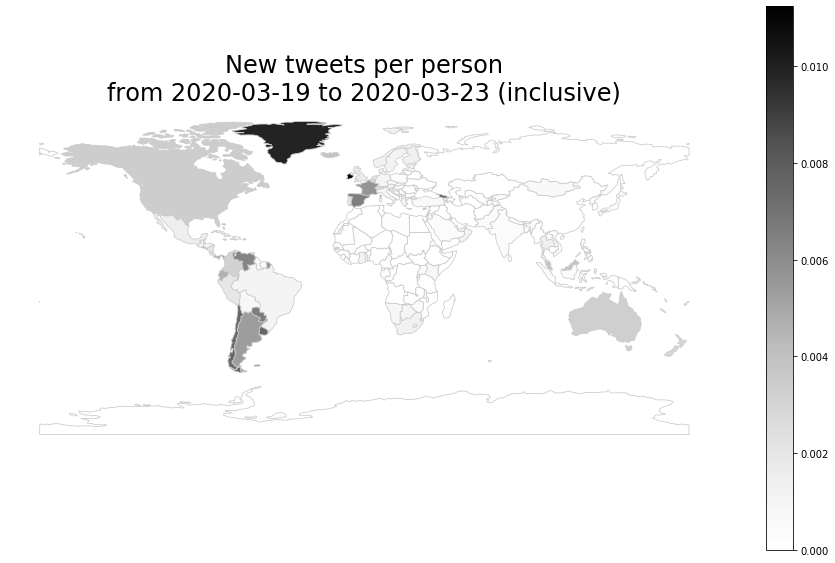

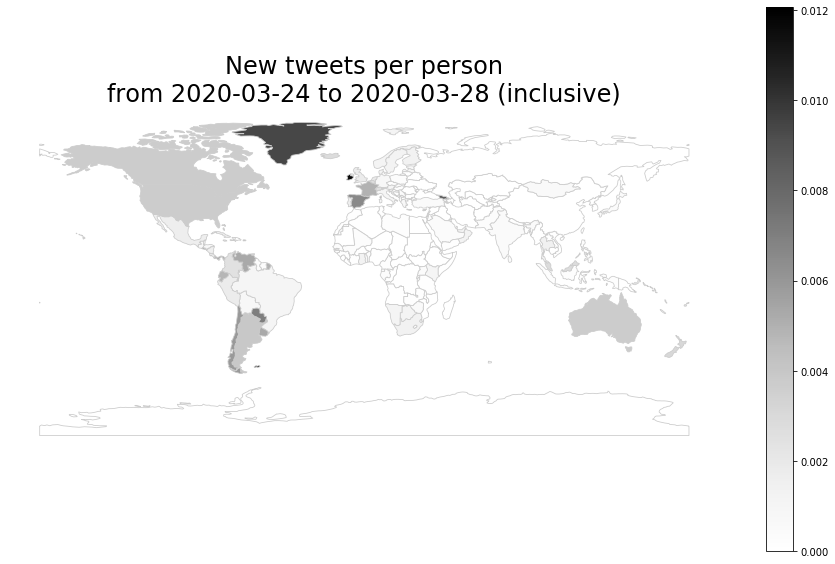

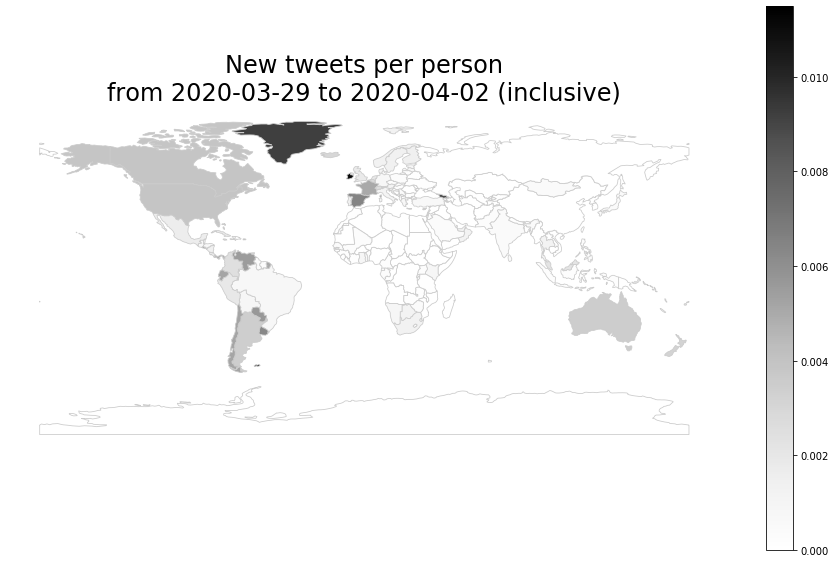

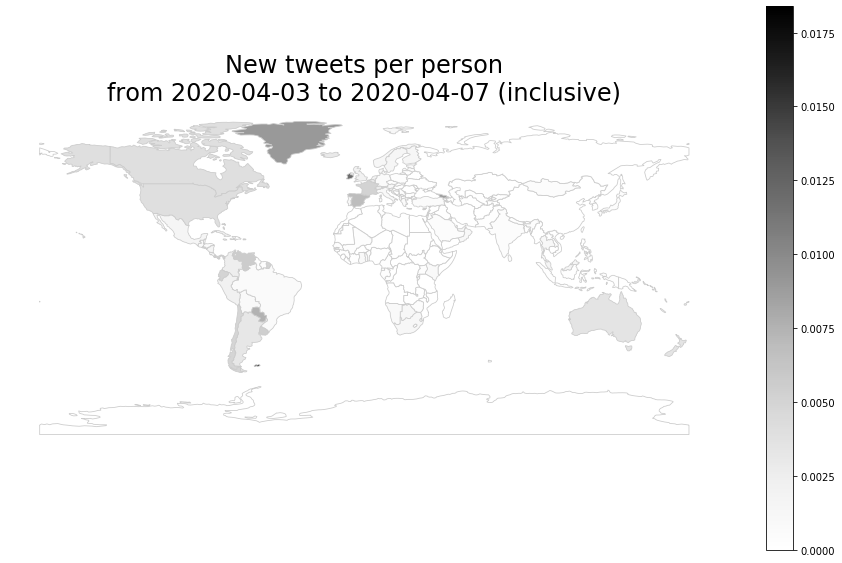

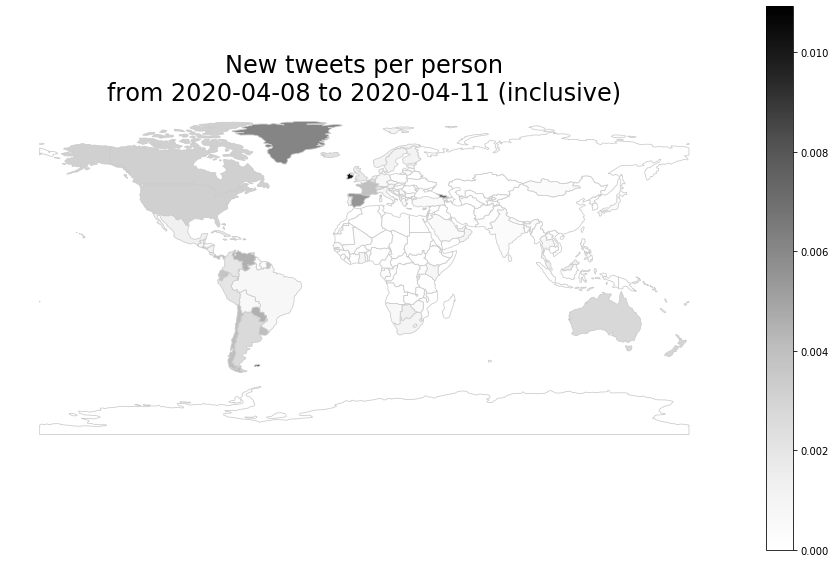

In [12]:
statistic_to_visualise = 'tweets per person'
dates_ranges_to_visualise = [
    (1, 5),
    (6, 10),
    (11, 15),
    (16, 20),
    (21, 25),
    (26, 30),
    (31, 34),
]

visualize_statistic_for_dates_range(dates_ranges_to_visualise, statistic_to_visualise)